In [2]:
%%capture 

import numpy as np 
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Importing Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
import warnings
from PIL import Image
from glob import glob

plt.style.use('default')
sns.set_theme()
warnings.filterwarnings('ignore')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder


### Setting Seed

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
       
set_seed(42)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)
     

Using device cuda


### Data Loading

In [5]:
train_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
print("Training data shape:", train_df.shape)
print("\nFirst few rows of the dataset:")
display(train_df.head())

Training data shape: (9912, 14)

First few rows of the dataset:


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
train_img_dir = "/kaggle/input/petfinder-pawpularity-score/train"
train_images = glob(os.path.join(train_img_dir, "*.jpg"))

#adding image path to train_df
train_df["image_path"] = train_df["Id"].apply(lambda x: os.path.join(train_img_dir, x + ".jpg"))

train_df = train_df[train_df["image_path"].isin(train_images)]

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,image_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/kaggle/input/petfinder-pawpularity-score/trai...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/kaggle/input/petfinder-pawpularity-score/trai...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/kaggle/input/petfinder-pawpularity-score/trai...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/kaggle/input/petfinder-pawpularity-score/trai...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/kaggle/input/petfinder-pawpularity-score/trai...


In [7]:
test_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv')
print("Testing data shape:", test_df.shape)
print("\nFirst few rows of the dataset:")
display(test_df.head())

Testing data shape: (8, 13)

First few rows of the dataset:


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [8]:
test_img_dir = "/kaggle/input/petfinder-pawpularity-score/test"
test_images = glob(os.path.join(test_img_dir, "*.jpg"))

#adding image path to test_df
test_df["image_path"] = test_df["Id"].apply(lambda x: os.path.join(test_img_dir, x + ".jpg"))

test_df = test_df[test_df["image_path"].isin(test_images)]

test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,image_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,/kaggle/input/petfinder-pawpularity-score/test...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,/kaggle/input/petfinder-pawpularity-score/test...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,/kaggle/input/petfinder-pawpularity-score/test...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,/kaggle/input/petfinder-pawpularity-score/test...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,/kaggle/input/petfinder-pawpularity-score/test...


### Pet Data Class

In [8]:

class PetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        self.pawpularity_array = self.dataframe['Pawpularity'].astype('float32').values / 100.0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # img_id = self.dataframe.iloc[idx]['Id']
        # img_path = self.dataframe.iloc[img_id]['image_path']

        row = self.dataframe.iloc[idx]

        # print("ID", img_id)
        # print("Path", img_path)

        # Load Image
        image = Image.open(row['image_path']).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.pawpularity_array[idx], dtype=torch.float32)
        return image, label


### Data Transformation

In [48]:
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation(degrees=45),
            transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
            transforms.ColorJitter(brightness=0.6, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
            transforms.Grayscale(num_output_channels=3),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else: # validation and test images resized without any transformation
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])


### Splitting the dataset

In [10]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Train-validation split (80%-20%)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Create Dataset
train_dataset = PetDataset(train_data, transform=get_transforms(train=True))
val_dataset = PetDataset(val_data, transform=get_transforms(train=False))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}")

Train Size: 7929, Validation Size: 1983


### CNN Model with RELU Activation 

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # CNN Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Compute flattened size dynamically
        self.flatten_size = 128 * (224 // (2 ** 3)) * (224 // (2 ** 3))  # (H/2^3) due to 3 pooling layers

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 1)  # Single output for regression

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No activation for regression

        return x


### RMSE Loss Function

In [27]:
# Define custom RMSE loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

### Training Function

In [12]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, device='cuda', scheduler= None):
    model.to(device)
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0

        for images, scores in train_loader:
            images, scores = images.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, scores in val_loader:
                images, scores = images.to(device), scores.to(device)
                outputs = model(images)
                loss = criterion(outputs, scores)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("New best model saved!\n")

    # Plot Training & Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


### CNN with Adam Optimizer

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_CNN_1 = CNNModel().to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model_CNN_1.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler (ReduceLR on Plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_model(model_CNN_1, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device, scheduler = scheduler)


### CNN with AdamW Optimizer

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_CNN_2 = CNNModel().to(device)
criterion = RMSELoss()
optimizer = optim.AdamW(model_CNN_2.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler (ReduceLR on Plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_model(model_CNN_2, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device, scheduler = scheduler)


### CNN with Batch Normalization and more convolutional layers

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvanceCNN (nn.Module):
    def __init__(self):
        super(AdvanceCNN, self).__init__()

        # First Convolution Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size

        # Second Convolution Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Adaptive Pooling (Ensures compatibility with different input sizes)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)  # Single output for regression
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        # Convolution + BatchNorm + Activation + Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten for FC layer

        # Fully Connected Layers
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)  # No activation for regression

        return x


Epoch 1: Train Loss = 0.3591, Val Loss = 0.2316
New best model saved!

Epoch 2: Train Loss = 0.2351, Val Loss = 0.2196
New best model saved!

Epoch 3: Train Loss = 0.2145, Val Loss = 0.2135
New best model saved!

Epoch 4: Train Loss = 0.2138, Val Loss = 0.2175
Epoch 5: Train Loss = 0.2102, Val Loss = 0.2291
Epoch 6: Train Loss = 0.2097, Val Loss = 0.2101
New best model saved!

Epoch 7: Train Loss = 0.2073, Val Loss = 0.2089
New best model saved!

Epoch 8: Train Loss = 0.2072, Val Loss = 0.2121
Epoch 9: Train Loss = 0.2062, Val Loss = 0.2085
New best model saved!

Epoch 10: Train Loss = 0.2065, Val Loss = 0.2097


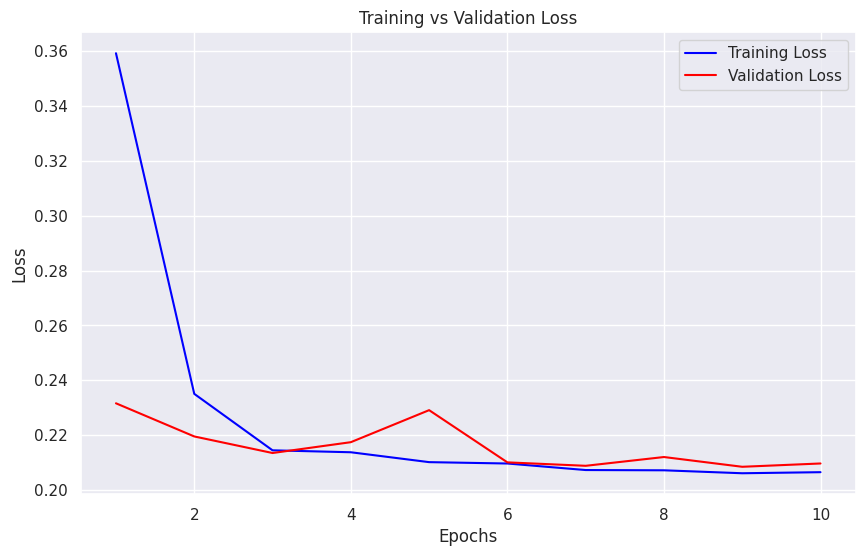

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_CNN_adv = AdvanceCNN().to(device)
criterion = RMSELoss()
optimizer = optim.AdamW(model_CNN_adv.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler (ReduceLR on Plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

train_model(model_CNN_adv, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device, scheduler = scheduler)


### Using MLP for Metadata

### Metadata Model

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

class MetadataMLP(nn.Module):
    def __init__(self, input_dim):
        super(MetadataMLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)  # First Hidden Layer
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm
        self.fc2 = nn.Linear(128, 64)   # Second Hidden Layer
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)     # Output Layer (Regression)

        self.dropout = nn.Dropout(0.3)  # Reduce Overfitting

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Apply BatchNorm + ReLU
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)  # No activation (Regression)
        return x


__main__.MetadataMLP

### Metadata Pet Dataset

In [24]:
# Load test dataset
class PetMetaDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.metadata_features = [col for col in df.columns if col not in ['Id', 'Pawpularity', 'image_path']]
        self.metadata_array = self.df[self.metadata_features].astype('float32').values
        self.pawpularity_array = self.df['Pawpularity'].astype('float32').values / 100.0
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
          metadata = torch.tensor(self.metadata_array[idx], dtype=torch.float32)
          label = torch.tensor(self.pawpularity_array[idx], dtype=torch.float32)
        
          return metadata, label

### Data Splitting

In [42]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Train-validation split (80%-20%)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Create Dataset
train_dataset_meta = PetMetaDataset(train_data)
val_dataset_meta = PetMetaDataset(val_data)

# Create DataLoaders
train_loader_metadata = DataLoader(train_dataset_meta, batch_size=32, shuffle=True)
val_loader_metadata = DataLoader(val_dataset_meta, batch_size=32, shuffle=False)


### Train Metadata Function

In [44]:
def train_metadata_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0


        for features, scores in train_loader:
            features, scores = features.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, scores.view_as(outputs))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)  # Store train loss

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, scores in val_loader:
                features, scores = features.to(device), scores.to(device)
                outputs = model(features)
                loss = criterion(outputs, scores.view_as(outputs))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Learning Rate Scheduler
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_metadata_model.pth')
            print(f"✅ New best model saved at Epoch {epoch+1} (Val Loss: {val_loss:.4f})")

    print("Training complete!")
    # Plot Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

### Training

Epoch 1: Train Loss 0.2782, Val Loss 0.2132
✅ New best model saved at Epoch 1 (Val Loss: 0.2132)
Epoch 2: Train Loss 0.2134, Val Loss 0.2093
✅ New best model saved at Epoch 2 (Val Loss: 0.2093)
Epoch 3: Train Loss 0.2095, Val Loss 0.2103
Epoch 4: Train Loss 0.2072, Val Loss 0.2099
Epoch 5: Train Loss 0.2063, Val Loss 0.2085
✅ New best model saved at Epoch 5 (Val Loss: 0.2085)
Epoch 6: Train Loss 0.2057, Val Loss 0.2079
✅ New best model saved at Epoch 6 (Val Loss: 0.2079)
Epoch 7: Train Loss 0.2050, Val Loss 0.2084
Epoch 8: Train Loss 0.2050, Val Loss 0.2080
Epoch 9: Train Loss 0.2047, Val Loss 0.2106
Epoch 10: Train Loss 0.2041, Val Loss 0.2111
Epoch 11: Train Loss 0.2037, Val Loss 0.2092
Epoch 12: Train Loss 0.2031, Val Loss 0.2084
Epoch 13: Train Loss 0.2032, Val Loss 0.2078
✅ New best model saved at Epoch 13 (Val Loss: 0.2078)
Epoch 14: Train Loss 0.2027, Val Loss 0.2072
✅ New best model saved at Epoch 14 (Val Loss: 0.2072)
Epoch 15: Train Loss 0.2027, Val Loss 0.2086
Epoch 16: Trai

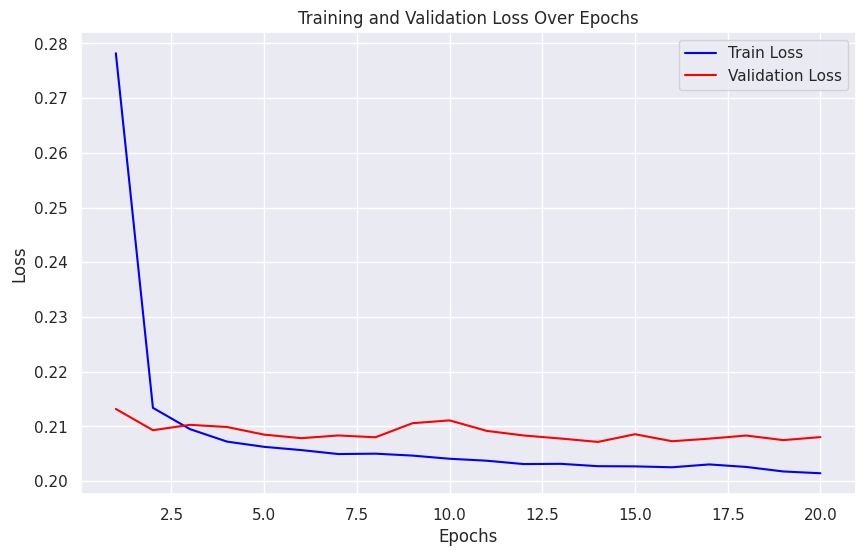

In [46]:
# Model, Loss, Optimizer
input_dim = len(train_df.columns)- 3
model_meta = MetadataMLP(input_dim).to(device)
criterion = RMSELoss()
optimizer = optim.AdamW(model_meta.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Train the model
train_metadata_model(model_meta, train_loader_metadata, val_loader_metadata, criterion, optimizer, scheduler, num_epochs=20, device=device)


### Metadata and Images both

### Class for both images and features

In [47]:
# Load test dataset
class PetMetaImgDataset(Dataset):
    def __init__(self, df,  transform=None):
        self.df = df
        self.transform = transform
        self.metadata_features = [col for col in df.columns if col not in ['Id', 'Pawpularity', 'image_path']]
        self.metadata_array = self.df[self.metadata_features].astype('float32').values
        self.pawpularity_array = self.df['Pawpularity'].astype('float32').values / 100.0
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
          row = self.df.iloc[idx]
          image = Image.open(row['image_path']).convert("RGB")
          if self.transform:
            image = self.transform(image)

          metadata = torch.tensor(self.metadata_array[idx], dtype=torch.float32)
          label = torch.tensor(self.pawpularity_array[idx], dtype=torch.float32)
        
          return image, metadata, label

### Data Splitting

In [49]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Train-validation split (80%-20%)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Create Dataset
train_dataset_meta_img = PetMetaImgDataset(train_data, transform=get_transforms(train=True))
val_dataset_meta_img = PetMetaImgDataset(val_data, transform=get_transforms(train=False))

# Create DataLoaders
train_loader_metadata_img = DataLoader(train_dataset_meta_img, batch_size=32, shuffle=True)
val_loader_metadata_img = DataLoader(val_dataset_meta_img, batch_size=32, shuffle=False)


### CNN model for img and feature

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNWithMetadata(nn.Module):
    def __init__(self, metadata_dim):
        super(CNNWithMetadata, self).__init__()

        # CNN Layers (Image Processing)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Compute flattened size dynamically
        self.flatten_size = 128 * (224 // (2 ** 3)) * (224 // (2 ** 3))  # 3 pooling layers

        # Fully Connected Layers for Image Features
        self.fc_img1 = nn.Linear(self.flatten_size, 512)
        self.fc_img2 = nn.Linear(512, 256)

        # Fully Connected Layers for Metadata Features
        self.fc_meta1 = nn.Linear(metadata_dim, 128)
        self.fc_meta2 = nn.Linear(128, 64)

        # Final Fully Connected Layers (Combining Image & Metadata)
        self.fc_combined1 = nn.Linear(256 + 64, 128)  # Combining Image + Metadata features
        self.fc_combined2 = nn.Linear(128, 1)  # Single output for regression

    def forward(self, image, metadata):
        # CNN Forward Pass (Image Processing)
        x = self.pool(F.relu(self.bn1(self.conv1(image))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc_img1(x))
        x = self.dropout(x)
        x = F.relu(self.fc_img2(x))

        # Metadata Forward Pass
        meta = F.relu(self.fc_meta1(metadata))
        meta = self.dropout(meta)
        meta = F.relu(self.fc_meta2(meta))

        # Concatenating Image and Metadata Features
        combined = torch.cat((x, meta), dim=1)

        # Final Fully Connected Layers
        combined = F.relu(self.fc_combined1(combined))
        output = self.fc_combined2(combined)  # No activation for regression

        return output


### Training function for img and feature

In [52]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train_combined_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0

        for images, features, scores in train_loader:
            images, features, scores = images.to(device), features.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(images, features)  # Pass both images and features
            loss = criterion(outputs, scores.view_as(outputs))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)  # Store train loss

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, features, scores in val_loader:
                images, features, scores = images.to(device), features.to(device), scores.to(device)

                outputs = model(images, features)  # Pass both images and features
                loss = criterion(outputs, scores.view_as(outputs))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Learning Rate Scheduler
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_combined_model.pth')
            print(f"✅ New best model saved at Epoch {epoch+1} (Val Loss: {val_loss:.4f})")

    print("Training complete!")

    # Plot Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()


### Training

Epoch 1: Train Loss 0.3578, Val Loss 0.3581
✅ New best model saved at Epoch 1 (Val Loss: 0.3581)
Epoch 2: Train Loss 0.3576, Val Loss 0.3572
✅ New best model saved at Epoch 2 (Val Loss: 0.3572)
Epoch 3: Train Loss 0.3588, Val Loss 0.3568
✅ New best model saved at Epoch 3 (Val Loss: 0.3568)
Epoch 4: Train Loss 0.3582, Val Loss 0.3590
Epoch 5: Train Loss 0.3593, Val Loss 0.3564
✅ New best model saved at Epoch 5 (Val Loss: 0.3564)
Epoch 6: Train Loss 0.3589, Val Loss 0.3580
Epoch 7: Train Loss 0.3578, Val Loss 0.3579
Epoch 8: Train Loss 0.3582, Val Loss 0.3577
Epoch 9: Train Loss 0.3585, Val Loss 0.3564
Epoch 10: Train Loss 0.3584, Val Loss 0.3575
Training complete!


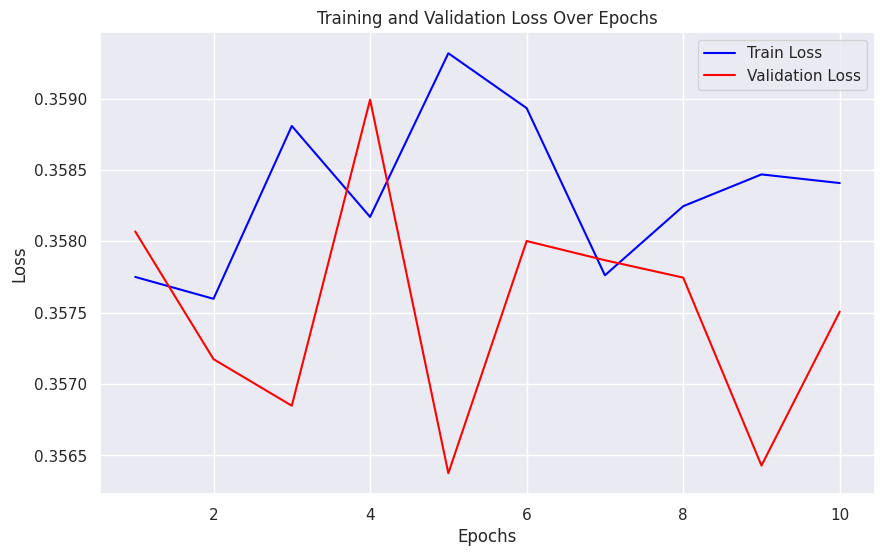

In [53]:
# Model initialization
metadata_dim = len(train_df.columns) -3  # Adjust based on your dataset
model = CNNWithMetadata(metadata_dim).to(device)

# Optimizer
optimizer = optim.AdamW(model_meta.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Loss Function (RMSE)
criterion = RMSELoss()

# Train the model
train_combined_model(model, train_loader_metadata_img, val_loader_metadata_img, criterion, optimizer, scheduler, num_epochs=10, device=device)


Thus combining images and features is not retriving in any good results here